<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# LightGBM: A Highly Efficient Gradient Boosting Decision Tree
This notebook gives an example of how to train a LightGBM model to generate point forecasts for product sales in retail. We will train a LightGBM model based on the Orange Juice dataset.

[LightGBM](https://github.com/Microsoft/LightGBM) is a gradient boosting framework that uses tree-based learning algorithms. [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is an ensemble technique in which models are added to the ensemble sequentially and at each iteration a new model is trained with respect to the error of the whole ensemble learned so far. More detailed information about gradient boosting can be found in this [tutorial paper](https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full). Using this technique, LightGBM achieves great accuracy in many applications. Apart from this, it is designed to be distributed and efficient with the following advantages:
* Fast training speed and high efficiency.
* Low memory usage.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

Due to these advantages, LightGBM has been widely used in a lot of [winning solutions](https://github.com/microsoft/LightGBM/blob/master/examples/README.md#machine-learning-challenge-winning-solutions) of machine learning competitions.

## Global Settings and Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import math
import datetime
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import scrapbook as sb
import matplotlib.pyplot as plt

from fclib.common.utils import git_repo_path
from fclib.models.lightgbm import predict
from fclib.evaluation.evaluation_utils import MAPE
from fclib.common.plot import plot_predictions_with_history
from fclib.dataset.ojdata import download_ojdata, split_train_test
from fclib.dataset.ojdata import FIRST_WEEK_START
from fclib.feature_engineering.feature_utils import (
    week_of_month,
    df_from_cartesian_product,
    combine_features,
)

warnings.filterwarnings("ignore")

print("System version: {}".format(sys.version))
print("LightGBM version: {}".format(lgb.__version__))

System version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
LightGBM version: 2.3.0


## Parameter Settings

In what follows, we define parameters related to the model and feature engineering. LightGBM supports both classification models and regression models. In our case, we set the objective function to `mape` which stands for mean absolute percentage error (MAPE) since we will build a regression model to predict product sales and evaluate the accuracy of the model using MAPE.

Generally, we can adjust the number of leaves (`num_leaves`), the minimum number of data in each leaf (`min_data_in_leaf`), the maximum number of boosting rounds (`num_rounds`), the learning rate of trees (`learning_rate`) and `early_stopping_rounds` (to avoid overfitting) in the model to get better performance. Besides, we can also adjust other supported parameters to optimize the results. [In this link](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst), a list of all the parameters is given. In addition, advice on how to tune these parameters can be found [in this URL](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst).

We will use historical weekly sales, date-time information, and product information as input features to train the model. Prior sales are used as lag features and `lags` contains the lags where each number indicates the number of time steps (i.e., weeks) that we shift the data backwards to get the historical sales. We also use the average sales within a certain time window in the past as a moving average feature. `window_size` controls the size of the moving window. Apart from these parameters, we use `use_columns` and `categ_fea` to denote all other features that we leverage in the model and the categorical features, respectively.


In [3]:
# Use False if you've already downloaded and split the data
DOWNLOAD_SPLIT_DATA = True

# Data directory
DATA_DIR = os.path.join(git_repo_path(), "ojdata")

# Forecasting settings
N_SPLITS = 1
HORIZON = 2
GAP = 2
FIRST_WEEK = 40
LAST_WEEK = 138

# Parameters of LightGBM model
params = {
    "objective": "mape",
    "num_leaves": 124,
    "min_data_in_leaf": 340,
    "learning_rate": 0.1,
    "feature_fraction": 0.65,
    "bagging_fraction": 0.87,
    "bagging_freq": 19,
    "num_rounds": 940,
    "early_stopping_rounds": 125,
    "num_threads": 16,
    "seed": 1,
}

# Lags, window size, and feature column names
lags = np.arange(2, 20)
window_size = 40
used_columns = ["store", "brand", "week", "week_of_month", "month", "deal", "feat", "move", "price", "price_ratio"]
categ_fea = ["store", "brand", "deal"]

## Data Preparation

We need to download the Orange Juice data and split it into training and test sets. By default, the following cell will download and spit the data. If you've already done so, you may skip this part by switching `DOWNLOAD_SPLIT_DATA` to `False`.

We store the training data and test data using dataframes. The training data includes `train_df` and `aux_df` with `train_df` containing the historical sales up to week 135 (the time we make forecasts) and `aux_df` containing price/promotion information up until week 138. Here we assume that future price and promotion information up to a certain number of weeks ahead is predetermined and known. The test data is stored in `test_df` which contains the sales of each product in week 137 and 138. Assuming the current week is week 135, our goal is to forecast the sales in week 137 and 138 using the training data. There is a one-week gap between the current week and the first target week of forecasting as we want to leave time for planning inventory in practice.

The setting of the forecast problem are defined in `fclib.dataset.ojdata.split_train_test` function. We can change this setting (e.g., modify the horizon of the forecast or the range of the historical data) by passing different parameters to this functions. Below, we split the data into `n_splits=1` splits, using the forecasting settings listed above in the **Parameter Settings** section.

In [4]:
if DOWNLOAD_SPLIT_DATA:
    download_ojdata(DATA_DIR)
    train_df_list, test_df_list, aux_df_list = split_train_test(
        DATA_DIR,
        n_splits=N_SPLITS,
        horizon=HORIZON,
        gap=GAP,
        first_week=FIRST_WEEK,
        last_week=LAST_WEEK,
        write_csv=True,
    )

    # Split returns a list, extract the dataframes from the list
    train_df = train_df_list[0].reset_index()
    test_df = test_df_list[0].reset_index()
    aux_df = aux_df_list[0].reset_index()

Data already exists at the specified location.


## Feature Engineering

Next we extract a number of features from the data for training the forecasting model including
* datetime features including week, week of the month, and month
* historical weekly sales of each orange juice in recent weeks
* average sales of each orange juice during recent weeks
* other features including `store`, `brand`, `deal`, `feat` columns and price features

Note that the logarithm of the unit sales is stored in a column named `logmove` both for `train_df` and `test_df`. We compute the unit sales `move` based on this quantity.

In [5]:
# Load training data
train_df["move"] = train_df["logmove"].apply(lambda x: round(math.exp(x)))
print(train_df.head(3))
print("")
train_df = train_df[["store", "brand", "week", "move"]]

# Create a dataframe to hold all necessary data
store_list = train_df["store"].unique()
brand_list = train_df["brand"].unique()
week_list = range(FIRST_WEEK, LAST_WEEK + 1)
d = {"store": store_list, "brand": brand_list, "week": week_list}
data_grid = df_from_cartesian_product(d)
data_filled = pd.merge(data_grid, train_df, how="left", on=["store", "brand", "week"])

# Get future price, deal, and advertisement info
data_filled = pd.merge(data_filled, aux_df, how="left", on=["store", "brand", "week"])

# Create relative price feature
price_cols = [
    "price1",
    "price2",
    "price3",
    "price4",
    "price5",
    "price6",
    "price7",
    "price8",
    "price9",
    "price10",
    "price11",
]
data_filled["price"] = data_filled.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
data_filled["avg_price"] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
data_filled["price_ratio"] = data_filled["price"] / data_filled["avg_price"]
data_filled.drop(price_cols, axis=1, inplace=True)

# Fill missing values
print("Number of missing rows is {}".format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
print("")
data_filled = data_filled.groupby(["store", "brand"]).apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))

# Create datetime features
data_filled["week_start"] = data_filled["week"].apply(lambda x: FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7))
data_filled["year"] = data_filled["week_start"].apply(lambda x: x.year)
data_filled["month"] = data_filled["week_start"].apply(lambda x: x.month)
data_filled["week_of_month"] = data_filled["week_start"].apply(lambda x: week_of_month(x))
data_filled["day"] = data_filled["week_start"].apply(lambda x: x.day)
data_filled.drop("week_start", axis=1, inplace=True)

# Create other features (lagged features, moving averages, etc.)
features = data_filled.groupby(["store", "brand"]).apply(
    lambda x: combine_features(x, ["move"], lags, window_size, used_columns)
)
train_fea = features[features.week <= max(train_df.week)].reset_index(drop=True)
print("Maximum training week number is {}".format(max(train_fea["week"])))
print("")

# Drop rows with NaN values
train_fea.dropna(inplace=True)
print(train_fea.head())

   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  move  
0  0.038984     1   0.0  37.992326  8256  
1  0.038984     0   0.0  30.126667  6144  
2  0.038984     0   0.0  30.000000  3840  

Number of missing rows is 6204

Maximum training week number is 135

    store  brand  week  week_of_month  month  deal  feat     move     price  \
19      2      1    59              4     10   1.0   0.0   8384.0  0.055625  

## Model Training

We then train a LightGBM model to predict the sales. After the model is trained, we apply it to generate forecasts for the target weeks.

In [6]:
# Create training set
dtrain = lgb.Dataset(train_fea.drop("move", axis=1, inplace=False), label=train_fea["move"])

# Train GBM model
print("Training LightGBM model...")
bst = lgb.train(params, dtrain, valid_sets=[dtrain], categorical_feature=categ_fea, verbose_eval=50)
print("")

# Generate forecasts
test_fea = features[(features.week >= min(test_df.week)) & (features.week <= max(test_df.week))].reset_index(drop=True)
idx_cols = ["store", "brand", "week"]
pred = predict(test_fea, bst, target_col="move", idx_cols=idx_cols).sort_values(by=idx_cols).reset_index(drop=True)
print("Prediction results:")
print(pred)

Training LightGBM model...
Training until validation scores don't improve for 125 rounds
[50]	training's mape: 0.311722
[100]	training's mape: 0.285767
[150]	training's mape: 0.274155
[200]	training's mape: 0.265833
[250]	training's mape: 0.260146
[300]	training's mape: 0.255795
[350]	training's mape: 0.252398
[400]	training's mape: 0.24973
[450]	training's mape: 0.247442
[500]	training's mape: 0.245553
[550]	training's mape: 0.243832
[600]	training's mape: 0.242123
[650]	training's mape: 0.240704
[700]	training's mape: 0.239503
[750]	training's mape: 0.238308
[800]	training's mape: 0.237258
[850]	training's mape: 0.236335
[900]	training's mape: 0.235512
Did not meet early stopping. Best iteration is:
[940]	training's mape: 0.234885

Prediction results:
      store  brand  week   move
0         2      1   137   9151
1         2      1   138  24055
2         2      2   137   4879
3         2      2   138  12035
4         2      3   137   2156
5         2      3   138   2414
6         2 

## Model Evaluation

To evaluate the model performance, we compute MAPE of the forecasts below.

In [7]:
# Evaluate prediction accuracy
test_df["actual"] = test_df["logmove"].apply(lambda x: round(math.exp(x)))
test_df.drop("logmove", axis=1, inplace=True)
combined = pd.merge(pred, test_df, on=["store", "brand", "week"], how="left")
metric_value = MAPE(combined["move"], combined["actual"]) * 100
sb.glue("MAPE", metric_value)
print("MAPE of the forecasts is {}".format(metric_value))

MAPE of the forecasts is 35.58242942761259


## Result Visualization

In the next, we plot out the feature importance learned by the model and the forecast results of a few sample store-brand combinations. Note that there could be gaps in the curve of actual sales due to missing sales data.

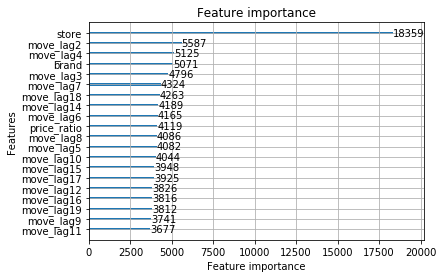

In [8]:
# Plot feature importances
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()

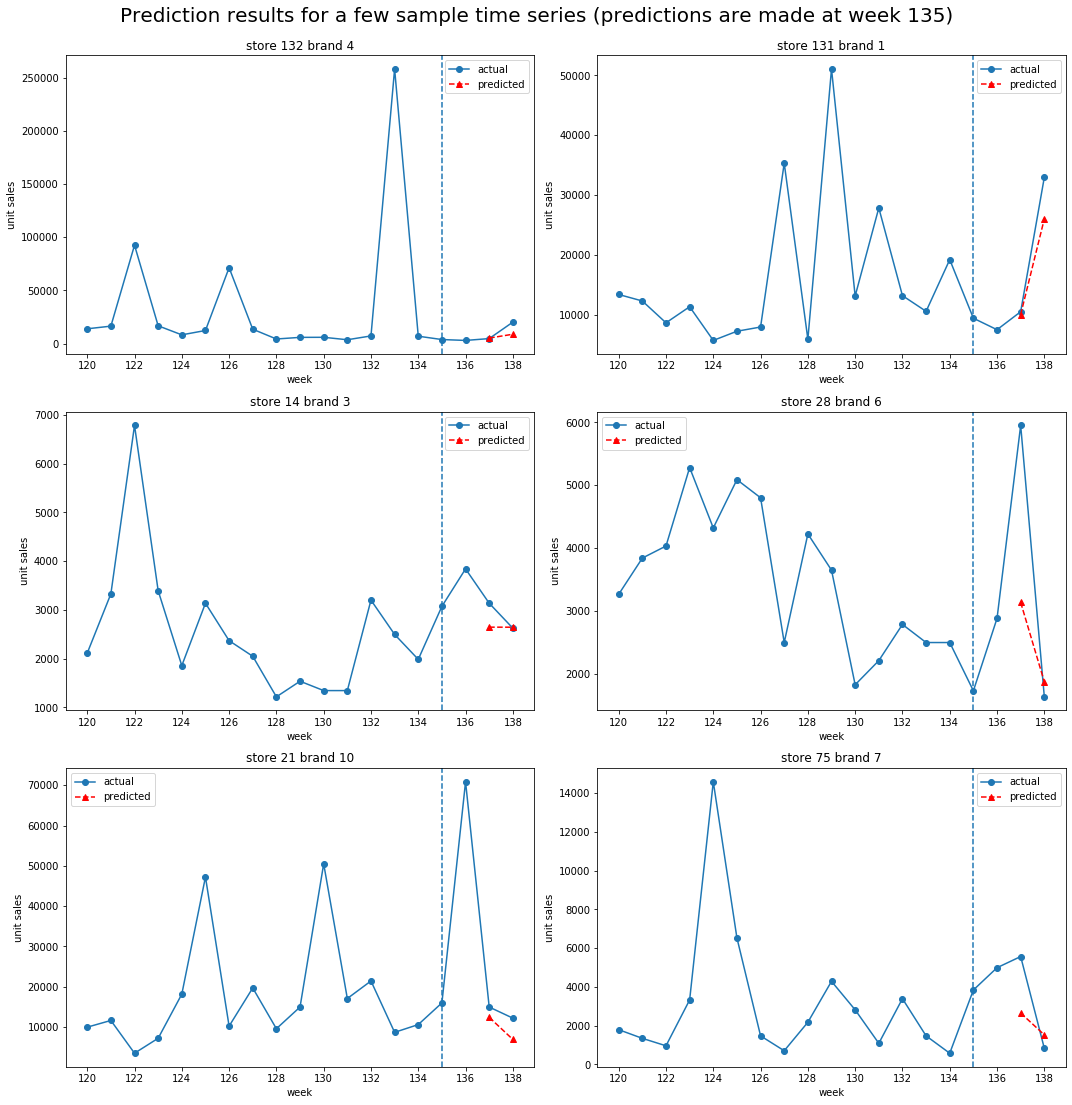

In [9]:
# Plot sample forecast results
num_samples = 6
min_week = 120
sales = pd.read_csv(os.path.join(DATA_DIR, "yx.csv"))
sales["move"] = sales["logmove"].apply(lambda x: round(math.exp(x)) if x > 0 else 0)

plot_predictions_with_history(
    combined,
    sales,
    grain1_unique_vals=store_list,
    grain2_unique_vals=brand_list,
    time_col_name="week",
    target_col_name="move",
    grain1_name="store",
    grain2_name="brand",
    min_timestep=min_week,
    num_samples=num_samples,
    predict_at_timestep=max(train_df.week),
    line_at_predict_time=True,
    title="Prediction results for a few sample time series (predictions are made at week 135)",
    x_label="week",
    y_label="unit sales",
    random_seed=2,
)

## Additional Reading

\[1\] Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, and Tie-Yan Liu. 2017. LightGBM: A highly efficient gradient boosting decision tree. In Advances in Neural Information Processing Systems. 3146–3154.<br>
\[2\] Alexey Natekin and Alois Knoll. 2013. Gradient boosting machines, a tutorial. Frontiers in neurorobotics, 7 (21). <br>
\[3\] The parameters of LightGBM: https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst <br>
\[4\] Anna Veronika Dorogush, Vasily Ershov, and Andrey Gulin. 2018. CatBoost: gradient boosting with categorical features support. arXiv preprint arXiv:1810.11363 (2018).<br>

